## ModelOptions vs SolverOptions


The distinction between **`ModelOptions`** and **`SolverOptions`** is essential when working with `optiwindnet`.
This notebook presents a clear and structured explanation of their roles and differences:

- **`ModelOptions`** define *how the optimization problem is formulated*, including structural assumptions and model features such as topology type, feeder constraints, and balancing requirements.
- **`SolverOptions`** configure *how the underlying solver behaves during execution*, controlling aspects like time limits, optimality gaps, and so on.

Understanding this separation helps ensure that models are both correctly formulated and efficiently solved.

---

### 🔧 What is `ModelOptions`?

`ModelOptions` is a configuration object or dictionary that **controls how the mathematical model is built and behaves**, regardless of the solver used. These options are typically **high-level**, problem-specific settings that:

* Affect the **structure** of the model (e.g., topology type)
* Enable or disable **features** (e.g., balancing constraints)
* Influence **heuristic/metaheuristic behavior** if used

#### ✅ Examples of `ModelOptions`:

| Parameter      | Description                                                                 |
| -------------- | --------------------------------------------------------------------------- |
| `topology`     | Controls whether the solution allows "radial" or "branched" subtrees        |
| `feeder_route` | Determines if feeder paths must be "straight" or may be "segmented"         |
| `feeder_limit` | Specifies limits on the number of feeders used in the solution              |
| `balanced`     | Whether subtree loads must be balanced                                      |
| `max_feeders`  | Required when `feeder_limit="specified"` to indicate the max number allowed |

These options **change the formulation** of the problem before it is handed to the solver.

### ModelOptions Capability of different routers

| Router           | Topology                                                              | Feeder Route                                                      | Feeder Limit                                                    |
|------------------|-----------------------------------------------------------------------|-------------------------------------------------------------------|------------------------------------------------------------------|
| **Heuristic**      | May produce *branched* or *radial* topologies; not user-controllable | **EW**: May yield *straight* or *segmented* routes; no control available  - **CPEW**: Always gives direct feeder-routes | Not controllable                                                 |
| **Metaheuristic**  | Always produces *radial* topology                                     | May yield *straight* or *segmented* routes; not user-controllable | Controllable via `feeder_limit` parameter in `ModelOptions`              |
| **MILP**           | Fully controllable via `topology` parameter in `ModelOptions`         | Fully controllable via `feeder_route` parameter in `ModelOptions`                   | Fully controllable via `feeder_limit` parameter in `ModelOptions`   |


In [8]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MetaHeuristic, MILP, ModelOptions, load_repository

In [9]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

Access ModelOptions help

In [10]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



## Optimize an examplary location

### Initialize Moray East

>In this example, the `load_repository()` functionality is used to load a prebuilt *Networkx.Graph*. For more details on this functionality look into the notebook about [Load repositories containing location data](api_02-load-repositories.ipynb).

In [11]:
locations = load_repository()
wfn = WindFarmNetwork(L=locations.seagreen, cables=5)

<Axes: >

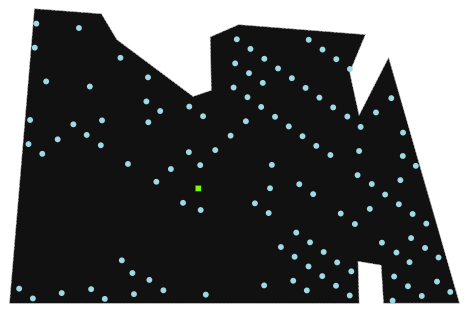

In [12]:
wfn.plot_location()

### ✅ Heuristic Solvers

**In the current version of `OptiWindNet`, `ModelOptions` are not supported by `Heuristic-Esau_Williams` and `Heuristic-CPEW`.**

* These solvers **do not accept `ModelOptions` as an argument**, and their behavior is unaffected by its settings.
* `CPEW` **always produces straight feeder routes** by design.
* Neither of the routers enforce **radial topologies** or **feeder limits**, even if such preferences are specified.

Optimize with `Heuristic-Esau_Williams`

<Axes: >

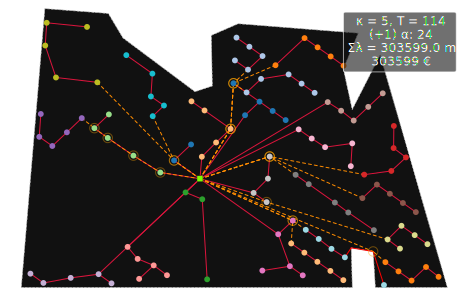

In [13]:
#
router_EW = Heuristic(solver='Esau_Williams')
res_EW= wfn.optimize(router=router_EW)
wfn.plot()

Optimize with `Heuristic-CPEW`

> Note that the feeder routes are direct.

<Axes: >

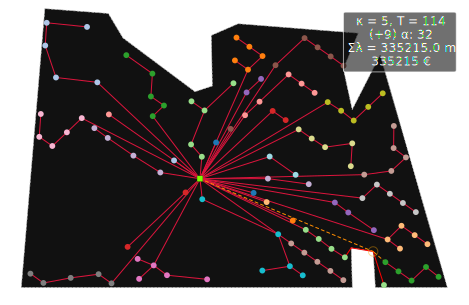

In [14]:
router_cpew = Heuristic(solver='CPEW')
res_cpew= wfn.optimize(router=router_cpew)
wfn.plot()

### Metaheuristic Solver (`HGS`)

**`Metaheuristic-HGS` does not support `ModelOptions` in its current format.**

* Instead, it accepts key configuration options, such as `feeder_limit` and `balanced`, as **individual arguments** passed directly to the router.

  * **Default values**:

    * `balanced = False`
    * `feeder_limit` is flexible and generally favors minimizing total cable length:

      * For locations with **one substation**, `feeder_limit` can be adjusted.
      * For locations with **multiple substations**, the `feeder_limit` argument is **ignored**, and the number of feeders is fixed to the **minimum required**.
* Other `ModelOptions` parameters, such as `topology` and `feeder_route`, are **not currently supported**.

<Axes: >

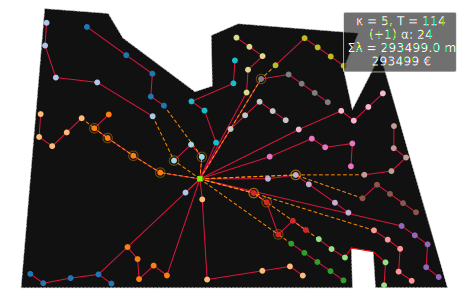

In [15]:
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=2)
res_hgs= wfn.optimize(router=router_hgs)
wfn.plot()

Set the `feeder_limit` lower than the possible minimum.

Vehicle number (20) too low for feasibilty with capacity (5). Setting to 23.


<Axes: >

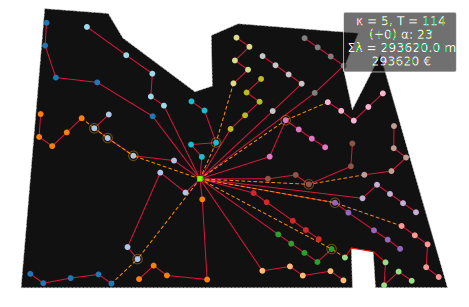

In [16]:
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=2, feeder_limit=20)
res_hgs= wfn.optimize(router=router_hgs)
wfn.plot()

<Axes: >

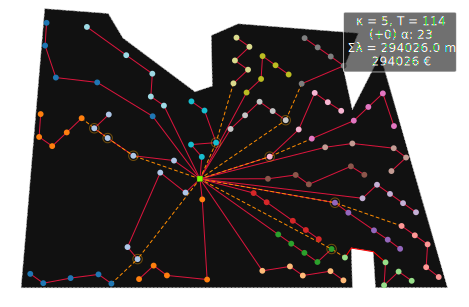

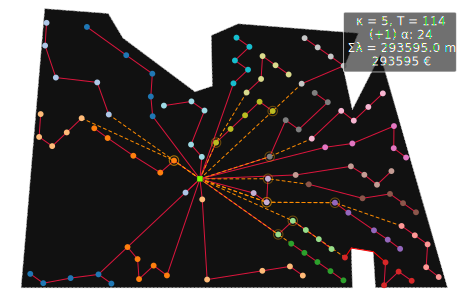

In [18]:
# create the logic of warmstarting for MILP

model_options = ModelOptions(
                        topology='radial',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )
router_hgs = MetaHeuristic(solver= 'HGS', time_limit=0.5, model_options=model_options)
res_EW= wfn.optimize(router=router_hgs)
wfn.plot()


model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='minimum',
                        feeder_route='straight',
)
router_hgs = MetaHeuristic(solver='HGS', time_limit=0.5, model_options=model_options)
res_EW= wfn.optimize(router=router_hgs)
wfn.plot()

#### Optimize again using `Heuristic-CPEW`

For `Heuristic-CPEW`, we run optimization with two sets of ModelOptions:


| Model Option   | Set 1       | Set 2       |
| -------------- | ----------- | ----------- |
| **topology**     | `branched`  | `radial`    |
| **feeder_limit** | `unlimited` | `minimum`   |
| **feeder_route** | `straight` | `segmented` |

With `Heuristic-CPEW`, we observe the following:

- **`topology='radial'`** has no effect on the solution.
  Although the resulting topology might be radial, this is not guaranteed. The `topology` setting in `ModelOptions` does not influence how `CPEW` constructs the solution.

- **`feeder_limit='minimum'`** has no effect on the solution.
  While the number of feeders may be low in the final layout, `CPEW` does not optimize for or enforce any constraint on the number of feeders. The `feeder_limit` parameter is ignored.

- **`feeder_route='segmented'`** does not control the behavior, but the result always complies.
  `CPEW` inherently produces layouts where all feeder routes are straight, regardless of the `feeder_route` setting in `ModelOptions`.

In summary, `Heuristic-CPEW` enforces straight feeder routes by design, but it does not take `ModelOptions` into account for topology or feeder limit. Any alignment with these options is incidental.

### Warmstarter Compatibility with ModelOptions

| **Model Option** | **Value**     | **Warmstarter**         |
|------------------|---------------|-------------------------|
| **Feeder limit** | Unlimited     | ✅ all works           |
|                  | Minimum       | only Metaheuristic-HGS  |
| **Feeder route** | Straight      | only Heuristic-CPEW     |
|                  | Segmented     | ✅ all works           |
| **Topology**     | Branched      | ✅ all works            |
|                  | Radial        | only Metaheuristic-HGS  |


In [19]:
model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='minimum',
                        feeder_route='straight',
                    )
#wfn.optimize(router=router_EW)
#wfn.optimize(router=router_cpew)
router_milp1 = MILP(solver_name='cplex', time_limit=30, mip_gap=0.01, model_options=model_options,  verbose=True)
res = wfn.optimize(router=router_milp1)


    - number of feeders (24) exceeds feeder limit (23)
    - detours present but feeder_route is set to "straight"



Version identifier: 22.1.2.0 | 2024-11-25 | 0edbb82fd
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                -1
CPXPARAM_Emphasis_MIP                            4
CPXPARAM_TimeLimit                               30
CPXPARAM_MIP_Tolerances_MIPGap                   0.01
Retaining values of one MIP start for possible repair.
Tried aggregator 1 time.
MIP Presolve eliminated 1124 rows and 0 columns.
MIP Presolve modified 1459 coefficients.
Reduced MIP has 4714 rows, 2396 columns, and 19537 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (20.26 ticks)
Probing time = 0.03 sec. (3.05 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4714 rows, 2396 columns, and 19537 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (15.56 ticks)
Probing time = 0.02 sec. (2.80 ticks)
Clique table members: 2087.
MIP emphasis: hid

In [20]:
wfn.plot()

<Axes: >

In [21]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



In [22]:
model_options = ModelOptions(
                        topology='radial',
                        feeder_limit='unlimited',
                        feeder_route='straight',
                    )

router_milp2 = MILP(solver_name='cplex', time_limit=15, mip_gap=0.005, model_options=model_options,  verbose=True)
res = wfn.optimize(router=router_milp2)


    - detours present but feeder_route is set to "straight"
    - branched structure not allowed under "radial" topology



Version identifier: 22.1.2.0 | 2024-11-25 | 0edbb82fd
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                -1
CPXPARAM_Emphasis_MIP                            4
CPXPARAM_TimeLimit                               15
CPXPARAM_MIP_Tolerances_MIPGap                   0.0050000000000000001
Retaining values of one MIP start for possible repair.
Found incumbent of value 1033133.765873 after 0.03 sec. (2.70 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1237 rows and 0 columns.
MIP Presolve modified 2543 coefficients.
Reduced MIP has 4713 rows, 2396 columns, and 18481 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (20.97 ticks)
Probing time = 0.02 sec. (2.92 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4713 rows, 2396 columns, and 18481 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (15.77 tick

In [23]:
res_cpew= wfn.optimize(router=router_cpew)
res = wfn.optimize(router=router_milp2)
wfn.length()


    - detours present but feeder_route is set to "straight"
    - branched structure not allowed under "radial" topology



Version identifier: 22.1.2.0 | 2024-11-25 | 0edbb82fd
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Parallel                                -1
CPXPARAM_Emphasis_MIP                            4
CPXPARAM_TimeLimit                               15
CPXPARAM_MIP_Tolerances_MIPGap                   0.0050000000000000001
Retaining values of one MIP start for possible repair.
Found incumbent of value 1033133.765873 after 0.02 sec. (2.70 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1237 rows and 0 columns.
MIP Presolve modified 2543 coefficients.
Reduced MIP has 4713 rows, 2396 columns, and 18481 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (20.97 ticks)
Probing time = 0.02 sec. (2.92 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 4713 rows, 2396 columns, and 18481 nonzeros.
Reduced MIP has 1198 binaries, 1198 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (15.77 tick

304255.52864890924

In [24]:
wfn.length()

304255.52864890924

In [25]:
router_milp2.optiwindnet_default_options

{'parallel': -1, 'emphasis_mip': 4}

In [26]:
wfn.plot()

<Axes: >

In [27]:
solver_options=dict(
    num_workers = 8,
)

model_options = ModelOptions(
                        topology='branched',
                        feeder_limit='unlimited',
                        feeder_route='segmented',
                    )

router_milp = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)

res = wfn.optimize(router=router_milp)

load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\ortools.dll...
>>> Using warm start: the model is initialized with the provided solution S <<<

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 15 log_search_progress: true relative_gap_limit: 0.01 num_workers: 8

Initial optimization 

### 🧮 What is `SolverOptions`?

`SolverOptions` refers to **solver-specific configuration parameters** that affect **how the solver works internally** (once the model is already built).

These settings are typically passed directly to a solver like CPLEX, Gurobi, CBC, etc., and influence:

* **Search strategy**
* **Runtime limits**
* **Optimality tolerances**
* **Logging and precision settings**

#### ✅ Common `SolverOptions` for MILP:

| Parameter      | Description                                           |
| -------------- | ----------------------------------------------------- |
| `time_limit`   | Maximum allowed solve time (in seconds)               |
| `gap`          | Optimality tolerance (e.g., 0.01 for 1% gap)          |
| `mip_emphasis` | Prioritize bound quality, feasibility, or integrality |
| `threads`      | Number of threads to use                              |

You can see the solveroptions modified by optiwindnet after creating an instance of the MILP solver via:
```python
router.optiwindnet_default_options
```

>If desired, set the logging level to `INFO` **before running `.optimize()` with the MILP router** to display detailed messages about the solver configuration and warm-start behavior:
>```python
>import logging
>logging.basicConfig(level=logging.INFO)
>```

In [28]:
router_ortools = MILP(solver_name='ortools', time_limit=15, mip_gap=0.01,  verbose=True)
router_ortools.optiwindnet_default_options

{}

In [29]:
router_cplex = MILP(solver_name='cplex', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cplex.optiwindnet_default_options

{'parallel': -1, 'emphasis_mip': 4}

In [30]:
router_cbc = MILP(solver_name='cbc', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

{'threads': 8,
 'timeMode': 'elapsed',
 'nodeStrategy': 'downFewest',
 'Dins': 'on',
 'VndVariableNeighborhoodSearch': 'on',
 'Rens': 'on',
 'Rins': 'on',
 'pivotAndComplement': 'off',
 'proximitySearch': 'off',
 'gomoryCuts': 'on',
 'mixedIntegerRoundingCuts': 'on',
 'flowCoverCuts': 'on',
 'cliqueCuts': 'off',
 'twoMirCuts': 'off',
 'knapsackCuts': 'off',
 'probingCuts': 'off',
 'zeroHalfCuts': 'off',
 'liftAndProjectCuts': 'off',
 'residualCapacityCuts': 'off'}

In [31]:
router_cbc = MILP(solver_name='gurobi', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

{'mipfocus': 1}

In [32]:
router_cbc = MILP(solver_name='highs', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

{}

In [33]:
router_cbc = MILP(solver_name='scip', time_limit=15, mip_gap=0.01, solver_options=solver_options,  verbose=True)
router_cbc.optiwindnet_default_options

{}

For a complete list of available options for each MILP solver, please refer to the corresponding solver's official documentation or user manual.

---

### 🆚 Key Differences between ModelOptions and SolverOptions

| Feature       | `ModelOptions`                                 | `SolverOptions`                           |
| ------------- | ---------------------------------------------- | ----------------------------------------- |
| Scope         | Problem formulation level                      | Solver execution level                    |
| Affects       | Model structure and constraints                | Search process and performance            |
| Applicable to | All methods (heuristics, metaheuristics, MILP) | Only solver-based methods (e.g., MILP)    |
| Examples      | `topology`, `feeder_limit`, `balanced`         | `time_limit`, `gap`, `threads`            |
| Impact        | Determines **what** is solved                  | Determines **how** it's solved            |
| Defined by    | The modeling framework                         | The specific solver (e.g., CPLEX, Gurobi) |

---

### 🎯 Summary

* **Use `ModelOptions`** to specify **what kind of solution** you want (structure, constraints, flexibility).
* **Use `SolverOptions`** to control **how long and how hard** the solver should try to find that solution.

After initializing the router, OptiWindNet sets a set of default options internally.
We can view the router options that were modified to match OptiWindNet’s preferred values using:

```python
router.optiwindnet_default_options
```

This attribute only reflects the options explicitly modified by OptiWindNet during initialization. MILP solvers typically support a much larger set of configurable options, which we can also adjust separately.
For example, in the case of the CBC solver, we can refer to its full list of options here:
[http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf](http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf)

> **Note:** Modifying any of the options originally set by OptiWindNet will not change the values stored in `optiwindnet_default_options`. However, the updated values will be used when solving the optimization problem.

In [34]:
router_milp.optiwindnet_default_options

{}

Similarly, we can view the default values used for the optimization model via:

```python
router.model_options
```

These `model_options` are not specific to the solver, they define settings related to the structure and behavior of the optimization model itself, rather than the router or solver configuration.

In [35]:
router_milp.model_options

{'topology': <Topology.BRANCHED: 'branched'>,
 'feeder_route': <FeederRoute.SEGMENTED: 'segmented'>,
 'feeder_limit': <FeederLimit.UNLIMITED: 'unlimited'>,
 'balanced': False,
 'max_feeders': 0}

A help for model options can be access via:

```python
ModelOptions.help()
```

In [36]:
ModelOptions.help()

topology in {"radial", "branched"} default: branched
    Set the topology of subtrees in the solution.

feeder_route in {"straight", "segmented"} default: segmented
    If feeder routes must be "straight" or can be detoured ("segmented").

feeder_limit in {"unlimited", "specified", "minimum", "min_plus1", "min_plus2", "min_plus3"} default: unlimited
    Whether to limit the maximum number of feeders, if set to "specified", additional kwarg "max_feeders" must be given.

balanced [bool] default: False
    Whether to enforce balanced subtrees (subtree loads differ at most by one unit).

max_feeders [int] default: 0
    Maximum number of feeders (used only if <feeder_limit = "specified">)



Solver options—including those set by OptiWindNet as well as additional configurable parameters—can be modified by creating a **dictionary** and passing it to the router. The same approach applies to **model options**.